## Setup

In [1]:
from tsai.all import *
my_setup()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


os              : Windows-10-10.0.19044-SP0
python          : 3.9.12
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.12.0
device          : 1 gpu (['NVIDIA GeForce GTX 1050'])
cpu cores       : 4
threads per cpu : 1
RAM             : 15.89 GB
GPU memory      : N/A


In [2]:
import wandb

wandb_username = "salih-atabey"
wandb_token = ""

!wandb login --relogin $wandb_token

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\salih/.netrc


In [3]:
wandb_run = wandb.init(
    project='ytd-cassandra-forecast', 
    entity='ytdteam'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: salih-atabey (ytdteam). Use `wandb login --relogin` to force relogin


In [4]:
config = dict(
    data = dict(
        look_back=60,
        news_power=2,
    ),
    model=dict(
        hidden_dim = 32,
        num_layers = 2,
        output_dim = 1,
    ),
    inference=dict(
    )
)

## NLP Model

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

nlp_tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
nlp_model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
nlp_classifier = pipeline("sentiment-analysis", model=nlp_model, tokenizer=nlp_tokenizer)

## Data

In [6]:
import pandas as pd
import numpy as np
import datetime

In [7]:
def load_stock_price_dataset(symbol):
    # Import stock price
    artifact = wandb_run.use_artifact('ytdteam/ytd-cassandra-forecast/meta-stock-price:v4', type='raw_data')
    artifact_dir = artifact.download()
    df_price = pd.read_csv(
            f"./{artifact_dir}/{symbol.lower()}.us.txt", 
            index_col='datetime', 
            parse_dates={'datetime': ['<DATE>', '<TIME>']},
            usecols=['<DATE>', '<TIME>', '<CLOSE>'], 
            na_values=['nan']
    ).rename(columns={'<CLOSE>': 'Close'})    
    # Import news 
    df_price['news_label'] = None
    df_price['news_score'] = None 
    artifact = wandb_run.use_artifact('ytdteam/ytd-cassandra-forecast/meta-financial-news:v2', type='raw_data')
    artifact_dir = artifact.download()
    df_news = pd.read_csv(
            f"./{artifact_dir}/{symbol.upper()}_news.csv", 
            index_col='datetime', 
            parse_dates={'datetime': ['Date']},
            usecols=['Date', 'title'], 
            na_values=['nan']
    ).rename(columns={'title': 'news'})    
    # Feed distilbert with news and append in data frame
    for news_ind in df_news[~df_news.index.duplicated()].index:
        if df_news.loc[news_ind].size == 1:
                news_sample = df_news.loc[news_ind]['news']
        else:
                news_sample = df_news.loc[news_ind]['news'].str.cat()
        df_news.drop(news_ind, inplace=True)
        df_news.loc[news_ind] = news_sample
        nlp_result = nlp_classifier(news_sample)
        if nlp_result[0]['label'] == 'positive':
                nlp_result_label = 1
        elif nlp_result[0]['label'] == 'neutral':
                nlp_result_label = 0
        elif nlp_result[0]['label'] == 'negative':
                nlp_result_label = -1
        nlp_result_score = nlp_result[0]['score']
        for price_ind in df_price[(df_price.index.year == news_ind.year) & (df_price.index.month == news_ind.month) & (df_price.index.day == news_ind.day)].index:
                df_price.loc[price_ind] = [df_price.at[price_ind, 'Close'], nlp_result_label, nlp_result_score**config['data']['news_power']]
    # Fill no news with neutral scores
    df_price['news_label'].fillna(0, inplace=True)
    df_price['news_score'].fillna(1, inplace=True)
    return df_price

In [8]:
import holidays
import pandas as pd
from pandas.api.types import CategoricalDtype


def is_us_holiday(dt):
    return dt.strftime("%Y-%m-%d") in holidays.UnitedStates()


def extract_datetime_features(ds):
    df = pd.DataFrame()
    df.index = ds
    df["year"] = ds.year
    df["month"] = ds.month
    df["day"] = ds.day
    df["hour"] = ds.hour
    df["day_of_year"] = ds.day_of_year
    df["week_of_year"] = ds.weekofyear
    df["month_name"] = ds.month_name()
    df["day_name"] = ds.day_name()
    df["is_weekend"] = (ds.day_of_week == 5) | (ds.day_of_week == 6)
    df["is_month_start"] = ds.is_month_start
    df["is_quarter_start"] = ds.is_quarter_start
    df["is_month_end"] = ds.is_month_end
    df["is_year_start"] = ds.is_year_start
    # US holidays
    df["is_holiday"] = pd.Series(ds.values).apply(is_us_holiday).values
    df["is_day_before_holiday"] = (
        pd.Series(ds + datetime.timedelta(days=1)).map(is_us_holiday).values
    )
    df["is_day_after_holiday"] = (
        pd.Series(ds - datetime.timedelta(days=1)).map(is_us_holiday).values
    )
    return df


def add_datetime_features(df):
    return pd.concat([extract_datetime_features(df.index), df], axis=1)


ORDINALS_INFO = []
ORDINALS = [feat for feat, _ in ORDINALS_INFO]

NOMINALS = [
    "hour",
    "month_name",
    "day_name",
    "is_weekend",
    "is_month_start",
    "is_quarter_start",
    "is_month_end",
    "is_year_start",
    "is_holiday",
    "is_day_before_holiday",
    "is_day_after_holiday",
]

NUMERICALS = ["day_of_year", "week_of_year", "price", "news_label", "news_score"]

UNUSED = [ ]

TARGET_VAR = "price"


def set_col_dtypes(dataf):
    dataf = dataf.drop(columns=UNUSED, errors="ignore")

    for col in NUMERICALS:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype("float")

    for col, categories in ORDINALS_INFO:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype(
            CategoricalDtype(categories=categories, ordered=True)
        )

    for col in NOMINALS:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype("category")

    existing_cols = set(dataf.columns)
    col_order = [
        col for col in NUMERICALS + ORDINALS + NOMINALS if col in existing_cols
    ]
    return dataf[col_order]


def prepare_dataset(df):
    return (
        pd.DataFrame(index=df.index, data=dict(price=df.Close.values, news_label=df.news_label.values, news_score=df.news_score.values))
        .pipe(add_datetime_features)
        .pipe(set_col_dtypes)
    )

In [9]:
SYMBOL = 'META'
df = (
    load_stock_price_dataset(SYMBOL)
    .pipe(prepare_dataset)
)
df.info()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1463 entries, 2022-01-25 16:00:00 to 2022-11-21 22:00:00
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   day_of_year            1463 non-null   float64 
 1   week_of_year           1463 non-null   float64 
 2   price                  1463 non-null   float64 
 3   news_label             1463 non-null   float64 
 4   news_score             1463 non-null   float64 
 5   hour                   1463 non-null   category
 6   month_name             1463 non-null   category
 7   day_name               1463 non-null   category
 8   is_weekend             1463 non-null   category
 9   is_month_start         1463 non-null   category
 10  is_quarter_start       1463 non-null   category
 11  is_month_end           1463 non-null   category
 12  is_year_start          1463 non-null   category
 13  is_holiday             1463 non-null   category
 14  is_d

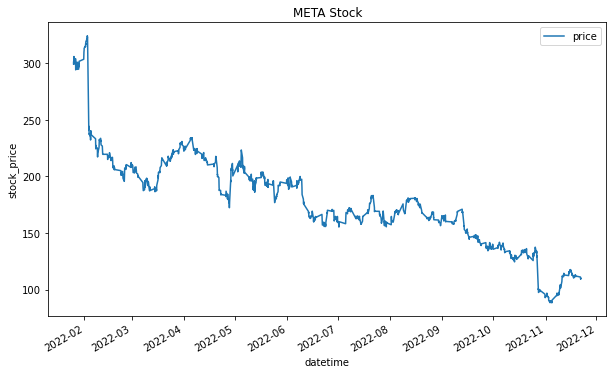

In [10]:
df[['price']].plot(figsize=(10, 6), subplots=True);
plt.ylabel("stock_price")
plt.title(f"{SYMBOL} Stock");

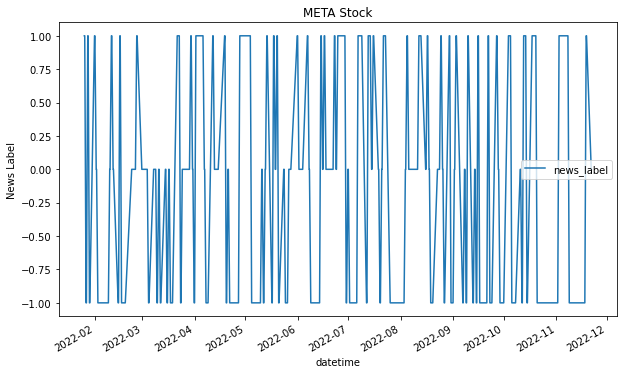

In [11]:
df[['news_label']].plot(figsize=(10, 6), subplots=True);
plt.ylabel("News Label")
plt.title(f"{SYMBOL} Stock");

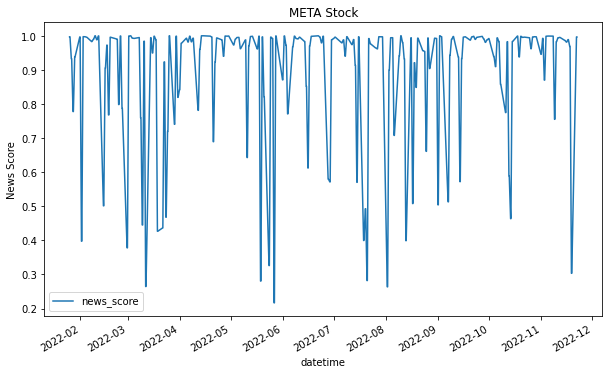

In [12]:
df[['news_score']].plot(figsize=(10, 6), subplots=True);
plt.ylabel("News Score")
plt.title(f"{SYMBOL} Stock");

### Train-Validation split

In [13]:
import datetime

def get_splits(df, cutoff_datetime):
    if isinstance(cutoff_datetime, str):
        cutoff_datetime = datetime.datetime.fromisoformat(cutoff_datetime)
    start_date = df.index.min()
    end_date = df.index.max()
    assert cutoff_datetime > start_date
    assert cutoff_datetime < end_date
    indices = np.arange(len(df))
    return indices[df.index < cutoff_datetime].tolist(), indices[df.index >= cutoff_datetime].tolist()

In [14]:
row_splits = get_splits(df, '2022-10-01')
len(row_splits[0]), len(row_splits[1]), len(row_splits[1]) / len(row_splits[0])

(1211, 252, 0.20809248554913296)

### Data encoding

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

def get_numerical_cols(dataf):
    return dataf.select_dtypes('number').columns.tolist()

def get_ordinal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if dataf[col].dtypes.ordered]

def get_nominal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if not dataf[col].dtypes.ordered]

def make_preprocessor(x_train: pd.DataFrame):
    numerical_cols = get_numerical_cols(x_train)

    num_transformer  = Pipeline([
        ('scaler', StandardScaler()),
    ])

    ordinal_cols = sorted(get_ordinal_cols(x_train))
    ordinal_category_list = [dt.categories.tolist() for dt in x_train[ordinal_cols].dtypes]
    ordinal_transformer = Pipeline([
        ('encoder', OrdinalEncoder(categories=ordinal_category_list, handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ])

    nominal_cols = sorted(get_nominal_cols(x_train))
    nominal_transformer = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ])

    preprocessor = Pipeline([
        (
            'preprocess', 
            ColumnTransformer([
                ('numerical', num_transformer, numerical_cols),
                ('ordinal', ordinal_transformer, ordinal_cols),
                ('nominal', nominal_transformer, nominal_cols),
            ], remainder='drop')
        )
    ]).fit(x_train)

    if nominal_cols:
        nominal_enc_cols = preprocessor.named_steps['preprocess'].transformers_[2][1].named_steps['encoder'].get_feature_names_out(nominal_cols).tolist()
    else:
        nominal_enc_cols = []
    
    preprocessor.feature_names_out_ = numerical_cols + ordinal_cols + nominal_enc_cols
    return preprocessor 

def make_target_preprocessor(y_train):
    return StandardScaler().fit(y_train.reshape(-1, 1))


In [16]:
xpp = make_preprocessor(df.iloc[row_splits[0]])
ypp = make_target_preprocessor(df.iloc[row_splits[0]][TARGET_VAR].values)
data_pp = xpp.transform(df)
data_pp.shape

(1463, 39)

## Prepare data 

In [17]:
import numpy as np
from more_itertools import windowed

def sliding_window(data, window_size: int):
    """Makes snippets of data for sequence prediction by sliding a window with size `look_back`
    Args:
        data (np.array): data with x and y values, shape = (T, F)
        window_size (int): window size
    """
    # shape = (N, W, F)
    return np.array(list(windowed(data, window_size)))

TARGET_IDX = df.columns.tolist().index(TARGET_VAR)
def make_ts_samples(data, look_back):
    snippets = sliding_window(data, look_back)
    x = np.swapaxes(snippets[:, :-1, :], 1, 2) # (N, W-1, F)
    y = snippets[:, -1, TARGET_IDX] # (N, )
    return x, y

In [18]:
def make_ts_dataset_split(train_x, train_y, val_x, val_y):
    x = np.concatenate([train_x, val_x], axis=0)
    y = np.concatenate([train_y, val_y], axis=0)
    splits = list(range(len(train_x))), list(range(len(train_x), len(x)))
    return x, y, splits

X      - shape: [1345 samples x 39 features x 59 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1345,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1152, 193]  overlap: False


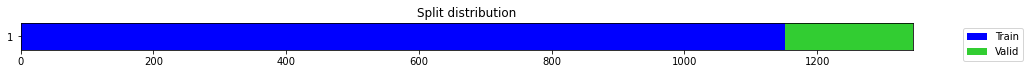

In [19]:
look_back = config['data']['look_back'] # choose sequence length
train_x, train_y = make_ts_samples(data_pp[row_splits[0]], look_back)
val_x, val_y = make_ts_samples(data_pp[row_splits[1]], look_back)
x, y, splits = make_ts_dataset_split(train_x, train_y, val_x, val_y)
check_data(x, y, splits)

## Build learner 🏗

* Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

In [20]:
from fastai.callback.wandb import *
from tsai.data.tabular import EarlyStoppingCallback

learn = TSRegressor(
    x, y, 
    splits=splits, 
    # arch=MLP,
    metrics=[rmse, mape], 
    bs=128, 
    train_metrics=True, 
    cbs=[
        ShowGraphCallback2(), 
        EarlyStoppingCallback(patience=3),
        # WandbCallback()
    ]
)

In [21]:
learn.loss_func

FlattenedLoss of MSELoss()

In [22]:
xb, yb = learn.dls.one_batch()

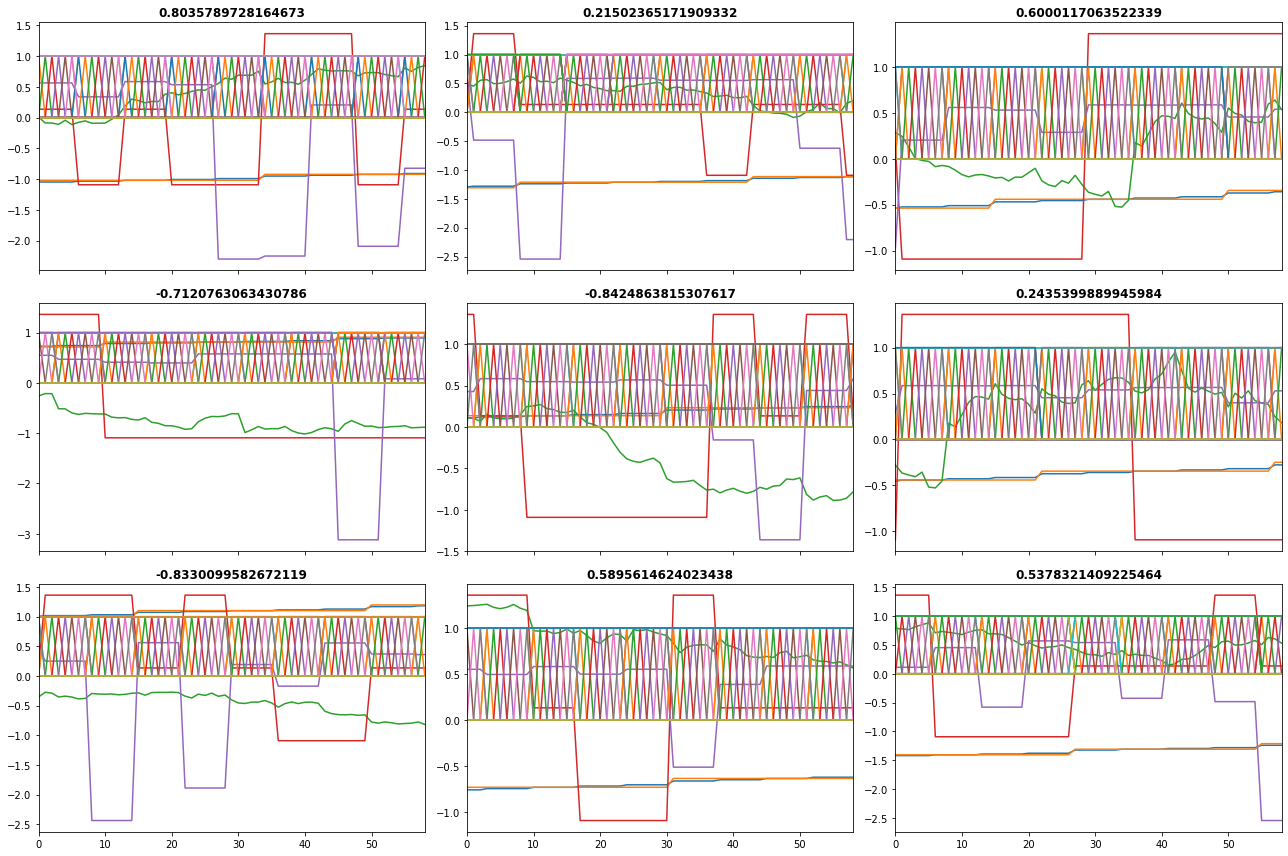

In [23]:
learn.dls.show_batch()

In [24]:
a = [1e-07, 2.154434690031883e-06, 4.641588833612777e-05, 0.001, 0.021544346900318822, 0.4641588833612782]

In [25]:
a[1//10:-5]

[1e-07]

SuggestedLRs(valley=0.0014454397605732083)

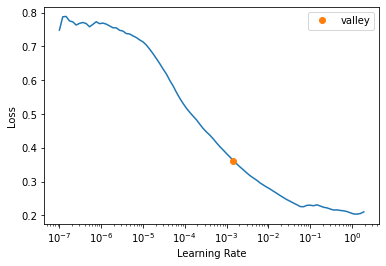

In [26]:
learn.lr_find()

## Train model

epoch,train_loss,train__rmse,train_mape,valid_loss,valid__rmse,valid_mape,time
0,0.539693,0.738854,28381320.000000,5.236762,2.288397,224403376.000000,00:00
1,0.329109,0.395039,15758263.000000,4.403154,2.098370,205189392.000000,00:00
2,0.239148,0.320635,15276372.000000,3.292638,1.814563,176668576.000000,00:00
3,0.179402,0.232965,10727361.000000,1.573651,1.254452,120714528.000000,00:00
4,0.136255,0.157374,6761324.500000,1.076176,1.037389,98461632.000000,00:00
5,0.105830,0.121883,4864306.000000,0.709491,0.842313,78492912.000000,00:00
6,0.084100,0.108311,4384042.000000,0.353202,0.594308,51643916.000000,00:00
7,0.068264,0.105245,4356275.000000,0.409546,0.639958,56896264.000000,00:00
8,0.056047,0.095099,3923245.250000,0.561681,0.749454,68597928.000000,00:00
9,0.046872,0.098578,3871777.750000,0.574756,0.758127,69345336.000000,00:00


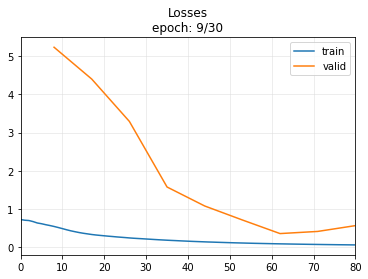

No improvement since epoch 6: early stopping


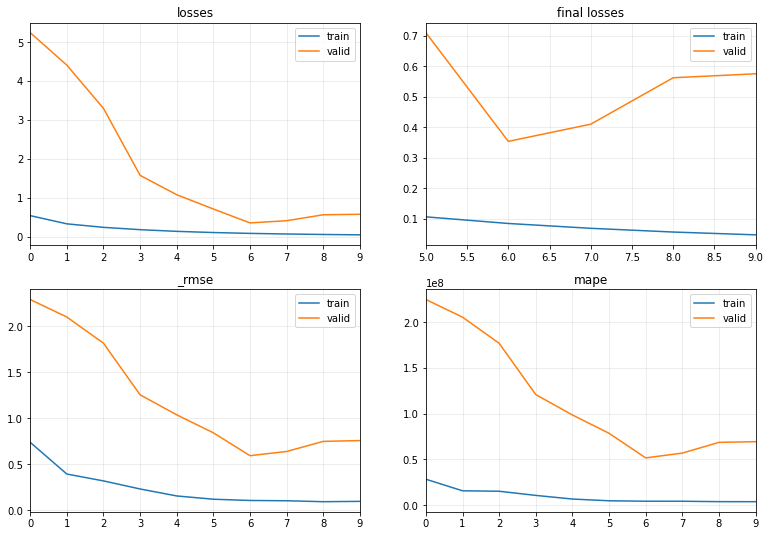

In [27]:
learn.fit_one_cycle(30, 3e-4)

In [28]:
wandb.finish()

## Export

In [29]:
from pathlib import Path
import wandb
import pickle

def log_file_artifact(wandb_run, path, name, type):
    artifact = wandb.Artifact(name, type=type)
    artifact.add_file(path)
    return wandb_run.log_artifact(artifact)

exports_path = Path('./models')
exports_path.mkdir(parents=True, exist_ok=True)

def log_learner(wandb_run, learn):
    path = exports_path / 'learn.pkl'
    learn.export(path)
    log_file_artifact(wandb_run, path, 'learn', type='model')
    return path

def log_preprocessor(wandb_run, pp, name):
    path = exports_path / f'{name}.pkl'
    with open(path, 'wb') as f:
        pickle.dump(pp, f)
    log_file_artifact(wandb_run, path, name, type='preprocessor')
    return path


In [30]:
learn.remove_cb(WandbCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.remove_cb(ShowGraph)

In [31]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,CastToTensor,ProgressCallback]

## Inference

In [32]:
xpp_export_path = log_preprocessor(wandb_run, xpp, 'x-preprocessor')
ypp_export_path = log_preprocessor(wandb_run, ypp, 'y-preprocessor')
learn_export_path = log_learner(wandb_run, learn)
print(xpp_export_path)
print(ypp_export_path)
print(learn_export_path)

models\x-preprocessor.pkl
models\y-preprocessor.pkl
models\learn.pkl


We'll now upload the saved learner and create the predictions:

In [33]:
xpp = pickle.load(open(xpp_export_path, "rb"))
ypp = pickle.load(open(ypp_export_path, "rb"))
learn = load_learner(learn_export_path)
xpp, ypp, learn

(Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('numerical',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['day_of_year',
                                                    'week_of_year', 'price',
                                                    'news_label',
                                                    'news_score']),
                                                  ('ordinal',
                                                   Pipeline(steps=[('encoder',
                                                                    OrdinalEncoder(categories=[],
                                                                                   handle_unknown='use_encoded_value',
                                                                                   unknown_value=nan)

In [34]:
def inverse_transform_target(y):
    return ypp.inverse_transform(np.array(y).reshape(-1, 1))

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def visualize_predictions(dates, prices, preds):
    prices = prices.reshape(-1, 1)
    preds = preds.reshape(-1, 1)

    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(dates, prices, color = 'red', label = 'Real Stock Price')
    axes.plot(dates, preds, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{SYMBOL} Stock Price')
    plt.legend()
    plt.show()

    for metric_name, metric, fmt in [
        ("MSE", mean_squared_error, ".4f"), 
        ("R2", r2_score, ".2%"),
        ("MAPE", mean_absolute_percentage_error, ".2%"),
    ]:
        score = metric(prices, preds)
        print(f"{metric_name}: {score:{fmt}}")


Baseline - Moving Average - Validation set


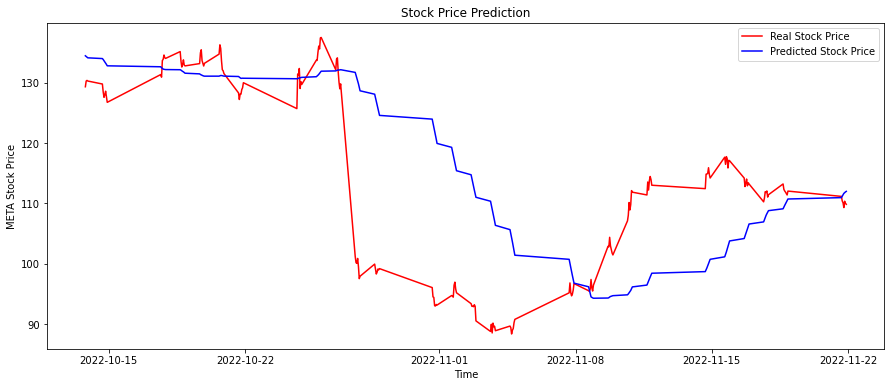

MSE: 184.4443
R2: 25.27%
MAPE: 9.72%


In [36]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

print("Baseline - Moving Average - Validation set")
print("="*32)

split = row_splits[1]
dates = df.iloc[split].index
prices = df.iloc[split]['price'].values
look_back = config['data']['look_back']
preds = moving_average(prices, look_back)
visualize_predictions(dates[look_back - 1:], prices[look_back - 1:], preds)

Baseline - Naive Forecast - Validation set


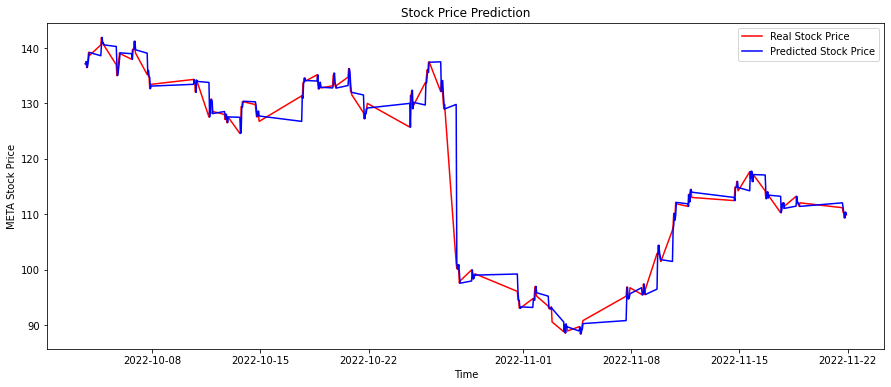

MSE: 5.6726
R2: 97.95%
MAPE: 1.04%


In [37]:
def baseline_naive_forecast(prices):
    return np.array([prices[0], *prices[:-1]])

print("Baseline - Naive Forecast - Validation set")
print("="*32)

split = row_splits[1]
dates = df.iloc[split].index
prices = df.iloc[split]['price'].values
preds = baseline_naive_forecast(prices)
visualize_predictions(dates, prices, preds)

Univariate LSTM - Validation set


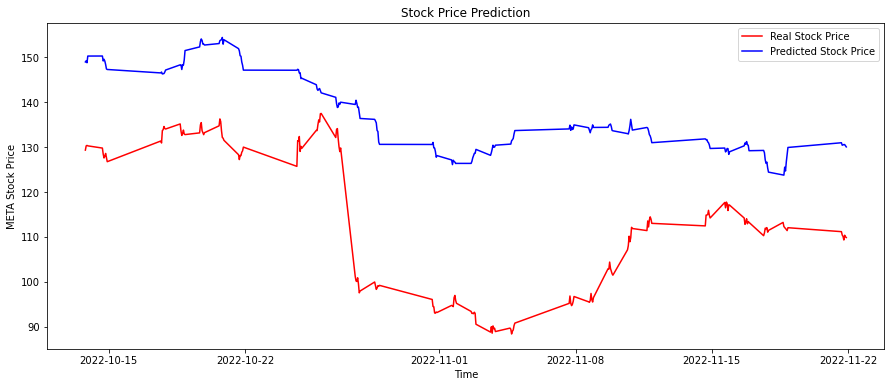

MSE: 684.3616
R2: -177.28%
MAPE: 22.75%


In [38]:
print("Univariate LSTM - Validation set")
print("="*32)
split = splits[1]
dates = df.iloc[row_splits[1]].index[look_back - 1:]
prices = inverse_transform_target(y[split])
_, _, y_pred = learn.get_X_preds(x[split])
preds = inverse_transform_target(y_pred)
visualize_predictions(dates, prices, preds)

Univariate LSTM - Training set


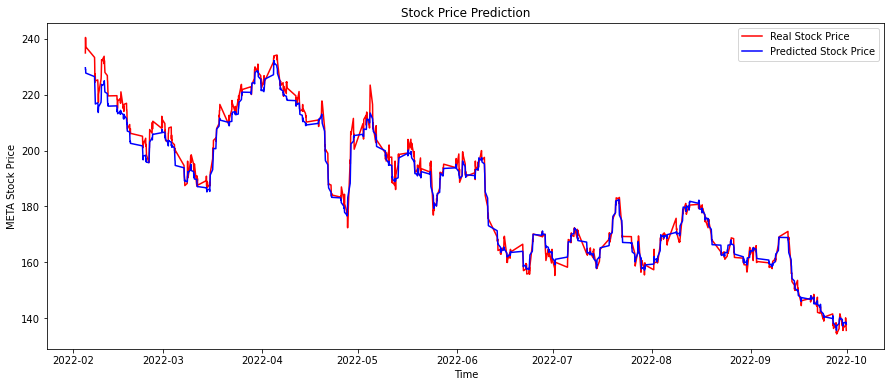

MSE: 7.5799
R2: 98.79%
MAPE: 1.07%


In [39]:
print("Univariate LSTM - Training set")
print("="*32)
split = splits[0]
dates = df.iloc[row_splits[0]].index[look_back - 1:]
prices = inverse_transform_target(y[split])
_, _, y_pred = learn.get_X_preds(x[split])
preds = inverse_transform_target(y_pred)
visualize_predictions(dates, prices, preds)
